In [47]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import OneClassSVM
from pylab import rcParams
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, roc_curve, auc, average_precision_score
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [48]:
# Dispalying Data Features

data = pd.read_csv('creditcard.csv',sep=',')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [49]:
# Information about Data

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [50]:
# Check if any featue data has a NULL value

data.isnull().values.any()

False

Fraud  --> class = 1
 (492, 31)
Normal --> class = 0
 (284315, 31)


Text(0, 0.5, 'Frequency')

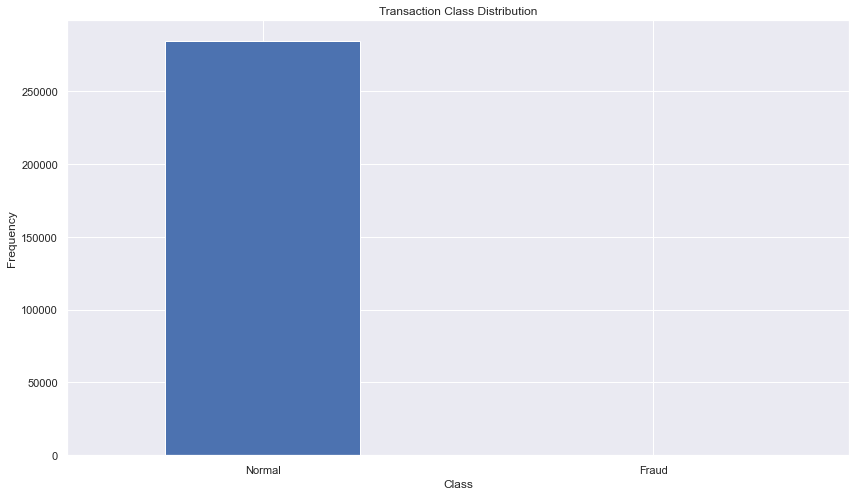

In [51]:
## Separate the Fraud and the normal transactions from original dataset 
## visualize the Data Points 

fraud = data[data['Class']==1]

normal = data[data['Class']==0]

print("Fraud  --> class = 1\n",fraud.shape)
print("Normal --> class = 0\n",normal.shape)

count_classes = pd.value_counts(data['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")

plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [37]:
## Analysis of Fraudulent Data
#How different are the amount of money used in different transaction classes?

fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [38]:
## Analysis of Normal Data
#How different are the amount of money used in different transaction classes?

normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

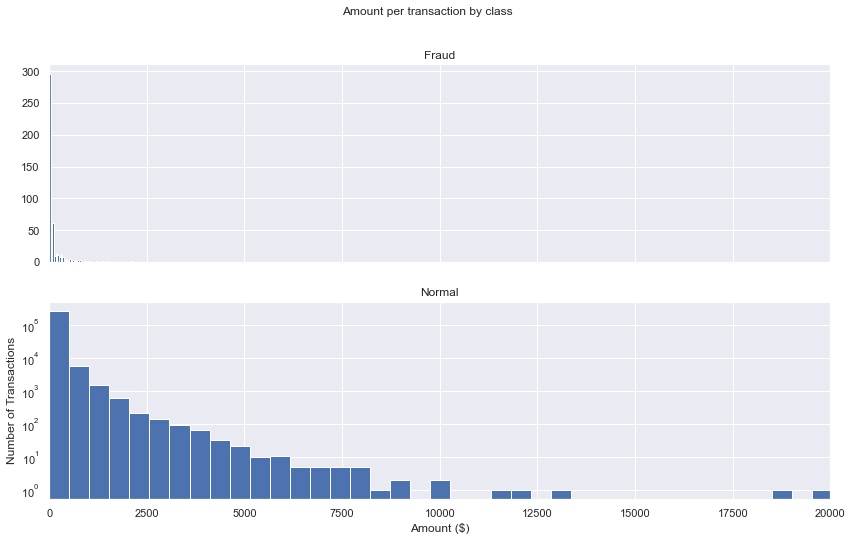

In [39]:
## Analize the data relation between Number of Transactions and Amount per Transaction for each class.

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

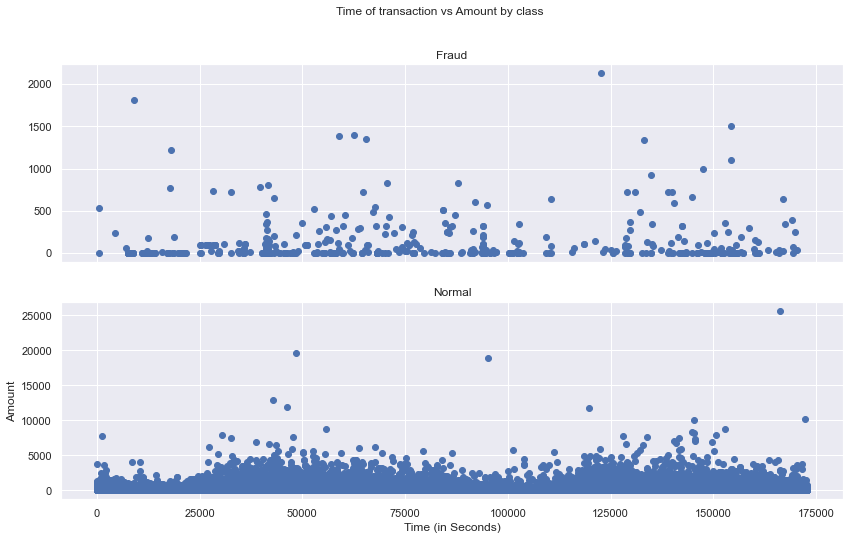

In [40]:
# Analyzing If fraudulent transactions occur more often during certain time frame ? 
# visual representation of Time of transaction vs Amount by class

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [41]:
# Sampling the data, for checking correlation and for few models,
#As the processing time for the huge original dataset is very high

data1= data.sample(frac = 0.1,random_state=1)

data1.shape

(28481, 31)

In [42]:
# Original dataset

data.shape

(284807, 31)

In [43]:
# Number of Fraudulent Transactions and Normal Transactions in our sample.(data1)

Fraud = data1[data1['Class']==1]

Valid = data1[data1['Class']==0]

outlier_fraction = len(Fraud)/float(len(Valid))

print(outlier_fraction)

print("Fraud Cases : {}".format(len(Fraud)))

print("Valid Cases : {}".format(len(Valid)))

0.0017234102419808666
Fraud Cases : 49
Valid Cases : 28432


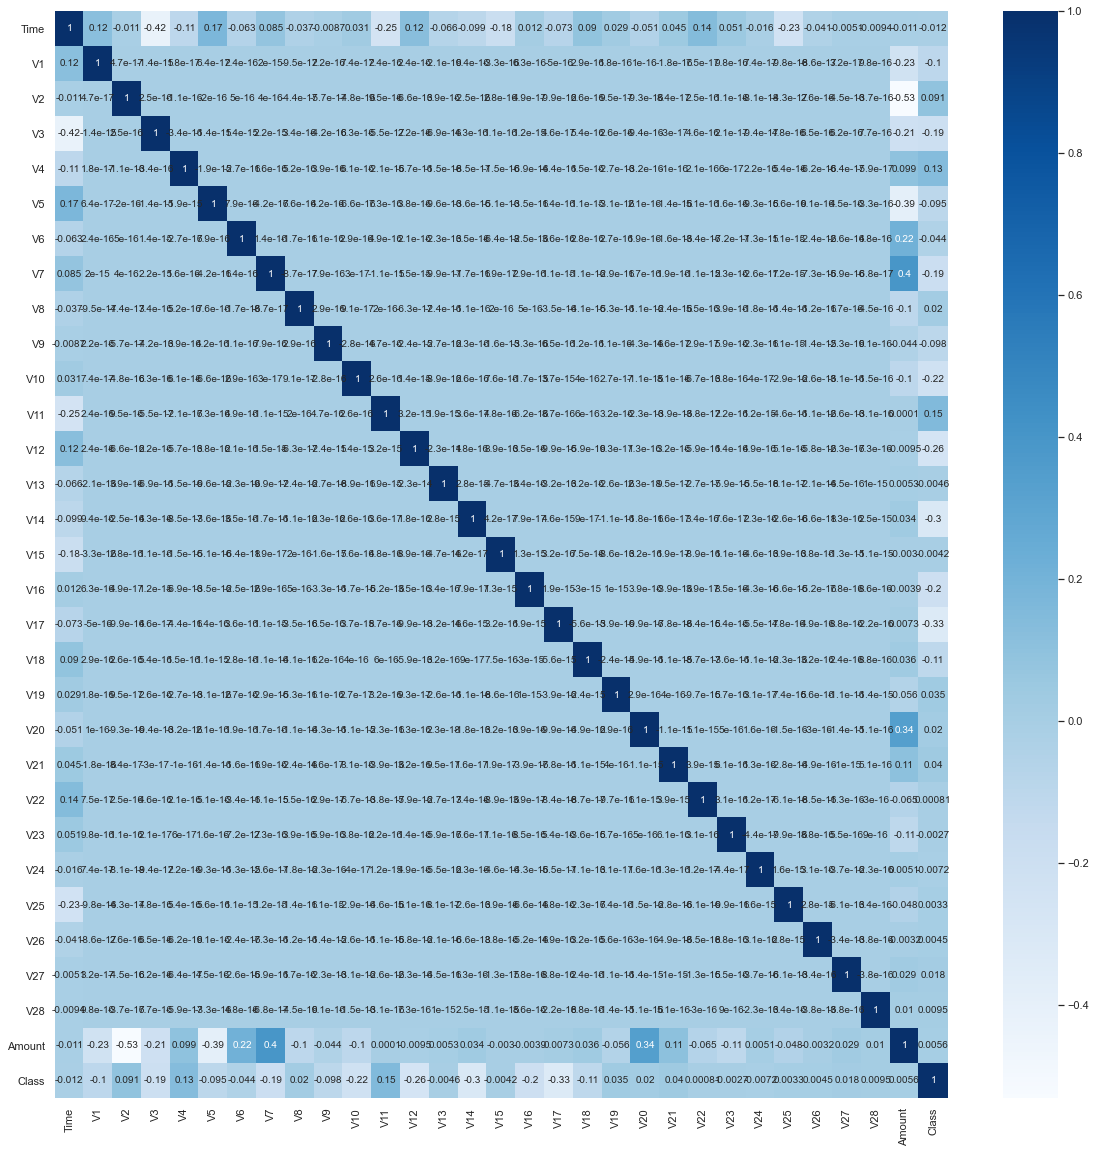

In [53]:
## Correlation

import seaborn as sns

#get correlations of each features in dataset

corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))

#plot heat map

g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="Blues")

In [52]:
Fraud = data[data['Class']==1]

Valid = data[data['Class']==0]

outlier_fraction = len(Fraud)/float(len(Valid))

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1)
   
}


In [24]:
##Define the outlier detection methods
#Determine the number of fraud and valid transactions in the dataset

from sklearn.ensemble import IsolationForest

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1)
   
}
type(classifiers)

dict

In [31]:


n_outliers = len(Fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

Isolation Forest: 73
Accuracy Score :
0.9974368877497279
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.26      0.27      0.26        49

    accuracy                           1.00     28481
   macro avg       0.63      0.63      0.63     28481
weighted avg       1.00      1.00      1.00     28481

Local Outlier Factor: 97
Accuracy Score :
0.9965942207085425
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.02      0.02      0.02        49

    accuracy                           1.00     28481
   macro avg       0.51      0.51      0.51     28481
weighted avg       1.00      1.00      1.00     28481

Support Vector Machine: 8516
Accuracy Score :
0.7009936448860644
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.70   

Test Accuracy of Logistic regression from scratch: 99.82%
The accuracy score achieved using Logistic Regression model from sklearn is: 99.92 %


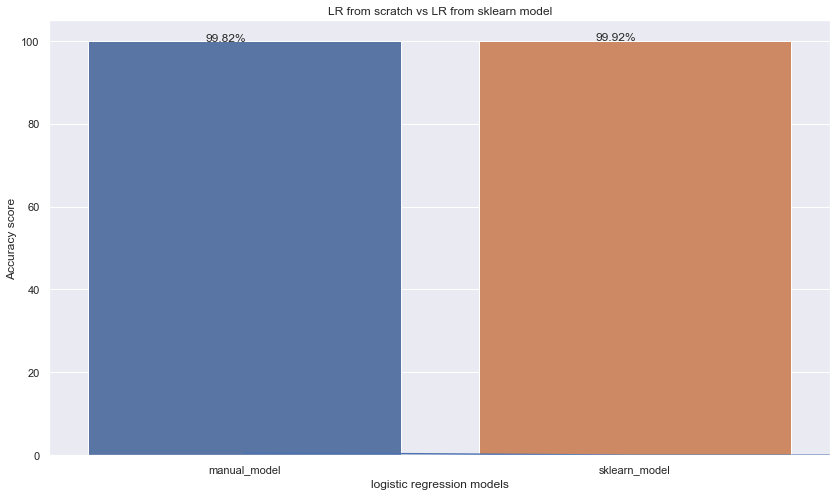

In [45]:
from sklearn.metrics import accuracy_score


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Logestic Regression

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def predict(weight, bias, x_test):
    z = np.dot(weight.T, x_test.T) + bias
    y_calculated = sigmoid(z)

    y_prediction = np.zeros((1, x_test.shape[0]))

    for i in range(y_calculated.shape[1]):
        if y_calculated[0, i] < 0.5:
            y_prediction[0, i] = 0
        else:
            y_prediction[0, i] = 1

    return y_prediction

def LR_train(weights, bias, x_train, y_train, learning_Rate, epochs):
    
    loss_list = []
    epoch_list = []

    for i in range(epochs):
        # forward
        y_calculated = sigmoid(np.dot(weights.T, x_train.T) + bias)
        
        lw = -(y_train * np.log(y_calculated) + (1 - y_train) * np.log(1 - y_calculated))
        """print("i= ", i)
        print("sum = ",np.sum(lw))"""
        
        loss = np.sum(lw) / x_train.shape[0]

        # Backward
        MLE_update = np.dot(x_train.T, ((y_calculated - y_train.T).T)) / x_train.shape[0]
        
        weights = weights - learning_Rate * MLE_update

        loss_list.append(loss)
        epoch_list.append(i)
        
        x_train, y_train = shuffle(x_train, y_train)
        

    plt.plot(epoch_list, loss_list)
    plt.xlabel("Number of Iteration")
    plt.ylabel("loss")
    #plt.show()

    return weights, bias

def logistic_regression(x_train, y_train, x_test, y_test, learningRate, epochs):
    # random weights [-0.05, 0.05] --> size = n_features (13)
    global score_manual
    weights = np.random.uniform(-0.05, 0.05, (x_train.shape[1], 1))
    
    bias = 0.0
    weights, bias = LR_train(weights, bias, x_train, y_train, learningRate, epochs)
    y_prediction = predict(weights, bias, x_test)
    
    print("Test Accuracy of Logistic regression from scratch: {:.2f}%".format((100 - np.mean(np.abs(y_prediction - y_test)) * 100) / 100 * 100))
    score_manual = round((100 - np.mean(np.abs(y_prediction - y_test)) * 100) / 100 * 100, 2)

score_manual = 0
# start of the program
# read data
data = pd.read_csv("creditcard.csv")

# store x and y values
y_true = data.Class.values
x_data = data.drop(['Class'], axis = 1)

# Normalize
x_data = (x_data - np.min(x_data)) / (np.max(x_data) - np.min(x_data)).values

# split the data 80% training and 20% testing
x_train, x_test, y_train, y_test = train_test_split(x_data, y_true, test_size = 0.20, random_state=4)


logistic_regression(x_train, y_train, x_test, y_test, learningRate=1, epochs=200)

# sklearn model
lr = LogisticRegression()
lr.fit(x_train,y_train)
Y_pred_lr = lr.predict(x_test)
score_lr = round(accuracy_score(Y_pred_lr,y_test)*100,2)

print("The accuracy score achieved using Logistic Regression model from sklearn is: "+str(score_lr)+" %")

sns.set(rc={'figure.figsize':(10,8)})
plt.xlabel("logistic regression models")
plt.ylabel("Accuracy score")
plt.title("LR from scratch vs LR from sklearn model")
models = ["manual_model", "sklearn_model"]
scores = [score_manual, score_lr]
ax=sns.barplot(models,scores)

i = 0
for p in ax.patches:
        #percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + 0.3
        y = p.get_y() + p.get_height() +0.1
        ax.annotate(str(scores[i])+"%", (x, y))
        i = i+1

plt.show()


In [46]:
print("Logistic Regression:")
print ("Accuracy: ",str(score_lr)+" %" )
print(classification_report(Y_pred_lr,y_test))

Logistic Regression:
Accuracy:  99.92 %
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56892
           1       0.63      0.91      0.75        70

    accuracy                           1.00     56962
   macro avg       0.82      0.96      0.87     56962
weighted avg       1.00      1.00      1.00     56962

